Download Dataset from Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rmisra/news-headlines-dataset-for-sarcasm-detection")

print("Path to dataset files:", path)

100%|██████████| 3.30M/3.30M [00:01<00:00, 2.79MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection/versions/2


JSON Handling

In [ ]:
import json
import os

json_file_path = os.path.join(path, "Sarcasm_Headlines_Dataset.json")

all_data = []
with open(json_file_path, 'r') as json_file:
    for line in json_file:
        entry = json.loads(line)
        all_data.append(entry)

texts = [item["headline"] for item in all_data]
labels = [item["is_sarcastic"] for item in all_data]

Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)



In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_len
        )
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SarcasmDataset(train_texts, train_labels, tokenizer)
val_dataset   = SarcasmDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)

In [6]:
from transformers import BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3

In [ ]:
model.train()

for epoch in range(epochs):
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Avg Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 | Avg Loss: 0.2562
Epoch 2 | Avg Loss: 0.1037
Epoch 3 | Avg Loss: 0.0419


In [14]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [15]:
SAVE_PATH = "/content/drive/MyDrive/sarcasm_bert"

model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

print("Model saved to Google Drive")


Model saved to Google Drive


In [16]:
from transformers import BertForSequenceClassification, BertTokenizer
import torch

LOAD_PATH = "/content/drive/MyDrive/sarcasm_bert"

tokenizer = BertTokenizer.from_pretrained(LOAD_PATH)
model = BertForSequenceClassification.from_pretrained(LOAD_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("Model loaded — ready for inference/evaluation")


Model loaded — ready for inference/evaluation


In [17]:
from sklearn.metrics import classification_report
import numpy as np

model.eval()
preds, true = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        preds.extend(predictions.cpu().numpy())
        true.extend(batch["labels"].cpu().numpy())

print(classification_report(true, preds, target_names=["Not Sarcastic", "Sarcastic"]))


               precision    recall  f1-score   support

Not Sarcastic       0.92      0.95      0.94      2996
    Sarcastic       0.93      0.90      0.92      2346

     accuracy                           0.93      5342
    macro avg       0.93      0.92      0.93      5342
 weighted avg       0.93      0.93      0.93      5342



In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)



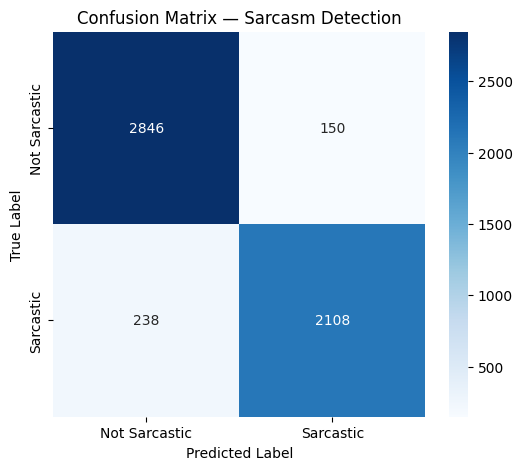

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ["Not Sarcastic", "Sarcastic"]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Sarcasm Detection")
plt.show()
